US Arrests Dataset Analysis - PCA and Clustering

This notebook analyzes the US arrest dataset to identify patterns in crime statistics across states. Analysis methods used were
Principal Component Analysis (PCA) for dimension reduction followed by two clustering methods: Hierarchical and K-means.

Import Libraries:

In [2]:
# Import Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, silhouette_score, confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import seaborn as sns

Load and Explore US Arrests Dataset:

Initial steps include loading the US Arrests dataset, which contains statistics on arrests per 100,000 residents for assault, murder,
and rape in each of the 50 states. The percentage of people living in urban areas is also given as 'Urbanpop'.

Dataset can be found here for download, save as 'UsArrests.csv' for compatibility with the workbook: 

- US Arrests Dataset: https://vincentarelbundock.github.io/Rdatasets/csv/datasets/USArrests.csv


In [3]:
# === Load Dataset ===
arrest_df = pd.read_csv('UsArrests.csv')

# Data exploration
print("First 5 rows of the US Arrests dataset:")
print(arrest_df.head())
print(f"\nUS Arrests dataset shape: {arrest_df.shape}")
print("\nUS Arrests dataset Stats:")
print(arrest_df.describe())

# Renaming 'City' column to 'State' and setting it as index
arrest_df.rename(columns={'City': 'State'}, inplace=True)
arrest_df.set_index('State', inplace=True)

print("\nChecking for missing values:")
print(arrest_df.isnull().sum())


First 5 rows of the US Arrests dataset:
         City  Murder  Assault  UrbanPop  Rape
0     Alabama    13.2      236        58  21.2
1      Alaska    10.0      263        48  44.5
2     Arizona     8.1      294        80  31.0
3    Arkansas     8.8      190        50  19.5
4  California     9.0      276        91  40.6

US Arrests dataset shape: (50, 5)

US Arrests dataset Stats:
         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000

Checking for missing values:
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


Initial Observations:
- Dataset contains 50 observations with 4 variables
- No missing values within dataset but changed name of variable 'City' to 'State' for context clarification
- 'Urbanpop' represents the percentage of urban population

Correlation Analysis:

Conducting analysis to better understand the relationships between variables and identify any underlying patterns.



Correlation Matrix:
            Murder   Assault  UrbanPop      Rape
Murder    1.000000  0.801873  0.069573  0.563579
Assault   0.801873  1.000000  0.258872  0.665241
UrbanPop  0.069573  0.258872  1.000000  0.411341
Rape      0.563579  0.665241  0.411341  1.000000


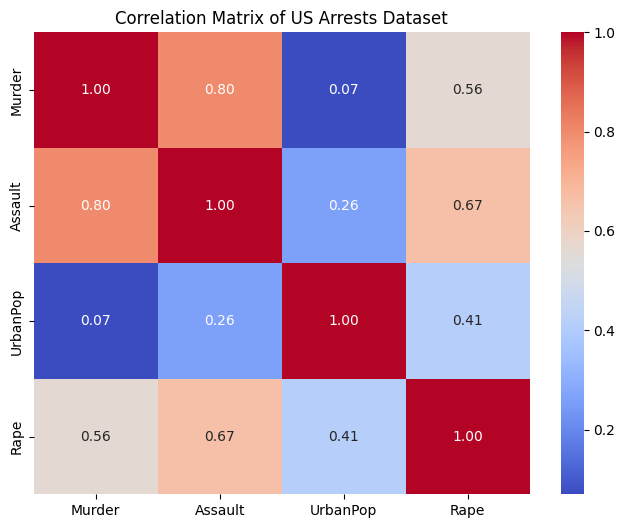

In [5]:
# Correlation Analysis
correlation_matrix = arrest_df.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of US Arrests Dataset')
plt.show()


Key Observations: 
- Strong positive correlation between 'Murder' and 'Assault' (.80): States with high murder rates will typically have high assault rates
- Moderate positive correlation between 'Assault' and 'Rape' (.66), 'Murder' and 'Rape' (.56): Violent crimes happen together usually
- Weak positive correlation between 'Urbanpop' and all variables: 'Urbanpop' does not strongly predict crime rates and other factors should alo be considered.


The data suggests that the crimes ('Murder', 'Rape', and 'Assault') share common underlying factors, making PCA a fitting model. 

Distribution Analysis:

Examining the distribution of each of the features to understand the data's spread to identify potential outliers or skewness.


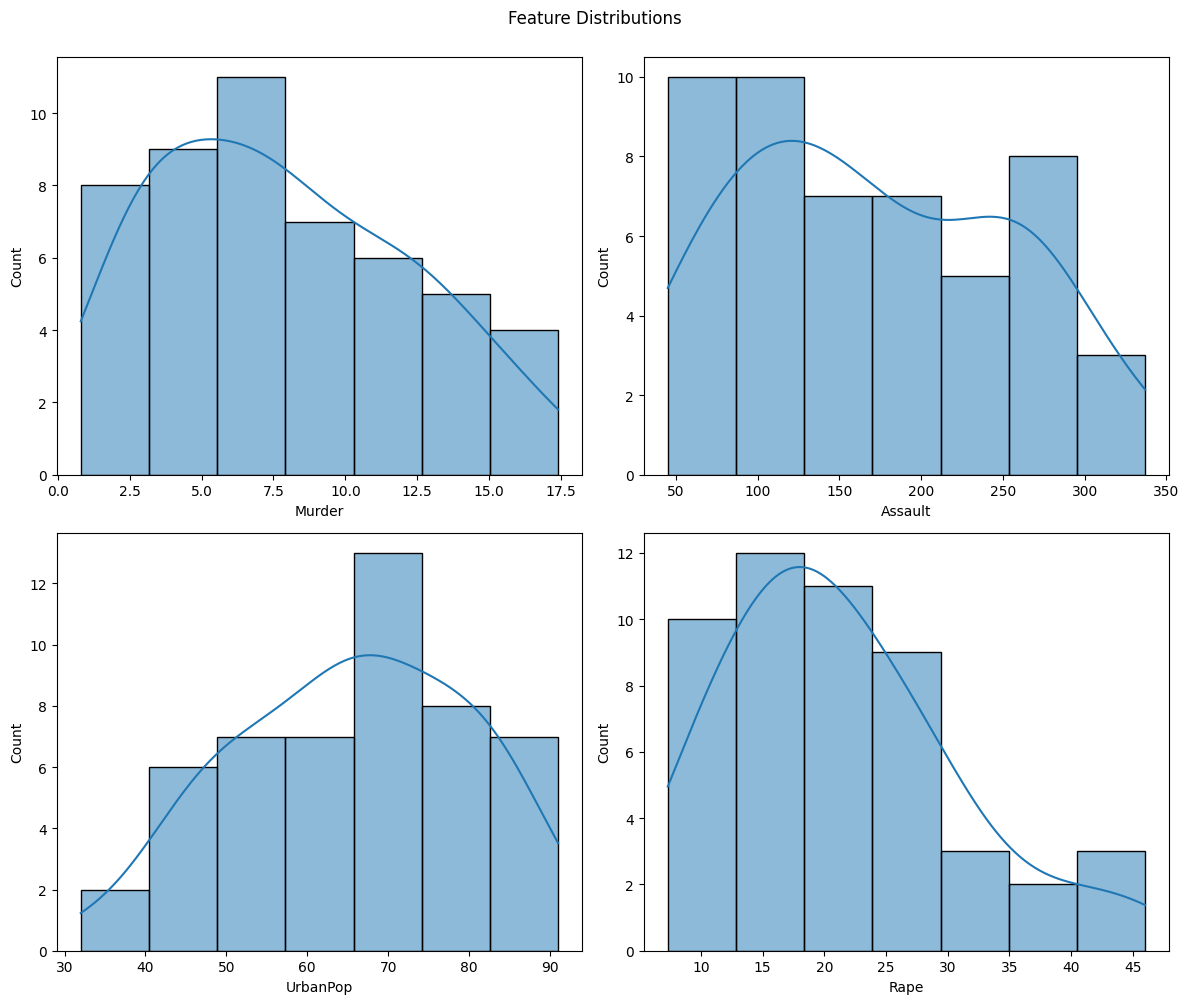


US Arrests dataset Stats:
         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000


In [7]:
# Distribution of features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
features = arrest_df.columns
for i, ax in enumerate(axes.flatten()):
    sns.histplot(arrest_df[features[i]], kde=True, ax=ax)
    plt.suptitle('Feature Distributions', y=1)
plt.tight_layout()
plt.show()

print("\nUS Arrests dataset Stats:")
print(arrest_df.describe())

Key Observations: 
- 'Murder': Skewed right with most States having lower rates than 10
- 'Assault': Has a wide spread with most states showing rates below 200
- 'Rape': Slight right skew with most states between 10-30 incidents per 100,000
- 'Urbanpop': Normal distribution with a slight left skew distribution centered around 65%

The varying scales and distributions within the variables indicates that standardization prior to the PCA is needed. 

Conduct PCA:

Principal Component Analysis helps reduce the dimensionality by creating new uncorrelated variables (Principal Components) that 
capture the maximum variance in the data. Indicating which combination of features will explain the variation amongst states. 

Data Standardization:
- Scaling the variables allows the PCA to ensure all features contribute equally to the analysis
- After standardization, all features will have a mean = 0 and standard deviation = 1

In [11]:
# Scale data prior to PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(arrest_df)
scaled_df = pd.DataFrame(scaled_data, columns=arrest_df.columns, index=arrest_df.index)

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_df)

# Show variance explained by each component
print("\nVariance Explained by Each Component:")
for i, variance in enumerate(pca.explained_variance_ratio_):
    print(f"Component {i+1}: {variance:.4f}")

# Show standard deviation
print("\nStandard Deviation of Each Component:")
for i, std_dev in enumerate(pca.singular_values_):
    print(f"Component {i+1}: {std_dev:.4f}")

# Calculate and show cumulative variance
print("\nCumulative Variance Explained:")
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
for i, cum_var in enumerate(cumulative_variance):
    print(f"Component {i+1}: {cum_var:.4f}")


Variance Explained by Each Component:
Component 1: 0.6201
Component 2: 0.2474
Component 3: 0.0891
Component 4: 0.0434

Standard Deviation of Each Component:
Component 1: 11.1361
Component 2: 7.0348
Component 3: 4.2223
Component 4: 2.9447

Cumulative Variance Explained:
Component 1: 0.6201
Component 2: 0.8675
Component 3: 0.9566
Component 4: 1.0000


PCA Observation:
- Primary Component 1 explains 62% of the total variance and is the most important component
- Primary Component 2 explains 25% of the total variance and is the second most important component
- Primary Component 1 + 2 explains 87% of the total variance
- Primary Component 1 + 2 + 3 explains for nearly all the variance at 96%

Based on the PCA, we are able to move from 4 to 2-3 dimensions and still be able to retain most of our information. 

Scree Plot:

From the results of our PCA indicate that the removal of dimensions will result in not much information lost. Using a Scree Plot to visualize the variance each component explains will help determine how many components to keep. Our aim will be to keep the model under 10% variance. 

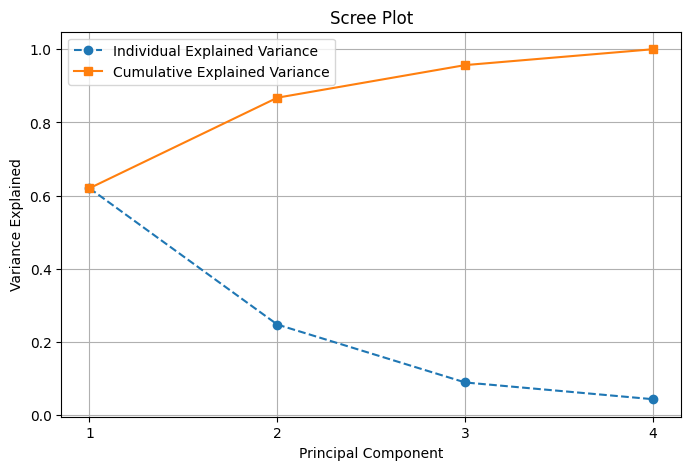

In [15]:
# Scree Plot to visualize explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o', linestyle='--', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='s', linestyle='-', label='Cumulative Explained Variance')
plt.legend()
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(pca.explained_variance_ratio_)+1))
plt.grid()
plt.show()


Key Observations:
- Elbow of the model occurs after Primary Component 2 and starts leveling off as more components are added
- Variance explained by Component 1 + 2 does not reach goal of only 10% unexplained variance

Reducing the model to 3 primary components, the model will be able to account for 96% of variance meeting our goal of 10% unexplained variance while also effectively making the the model more efficient. 

Biplot: 

The plot shows both the states (dots) and the original features (arrows) in the the PCA. The arrows reveal which features contribute to each principal component. 

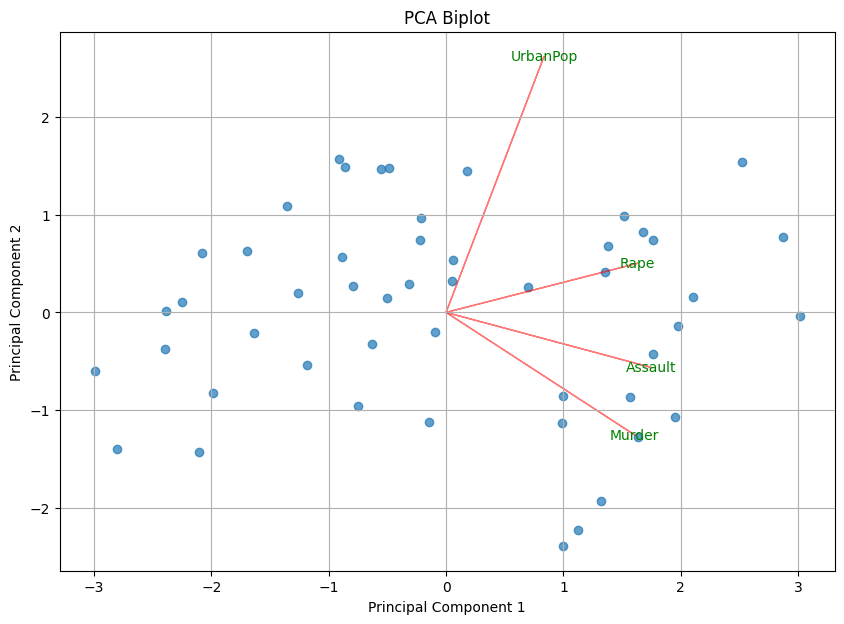

In [16]:
# Generate a Biplot to visualize PCA results
plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7)
for i, feature in enumerate(features):
    plt.arrow(0, 0, pca.components_[0, i]*3, pca.components_[1, i]*3,
              color='r', alpha=0.5)
    plt.text(pca.components_[0, i]*3, pca.components_[1, i]*3, feature, color='g', ha='center', va='center')
plt.title('PCA Biplot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


Key Observation: 

1. Primary Component 1 (horizontal axis)
- 'Murder', 'Assault' and 'Rape' all point strongly to the right
- States on the right have high crime rates while states on the left have low crime rates

2. Primary Component 2 (vertical axis)
- 'Urbanpop' points upward, while crim variables point slightly upward
- This captures the urban vs. rural dimension somewhat independently of crime

3. Arrow Length
- Longer arrows equal stronger contribution to the first two components
- 'Murder', 'Assault', and 'Rape' are the strongest contributors
- All crimes are pointing in similar directions confirming that the correlation is correct.

Hierarchical Clustering:

This clustering method will group states by building a tree structure on similarity, using wards method to minimize the with-in cluster variance. The dendogram will show how states are merged into clusters based on similarity.

Hierarchical Clustering:


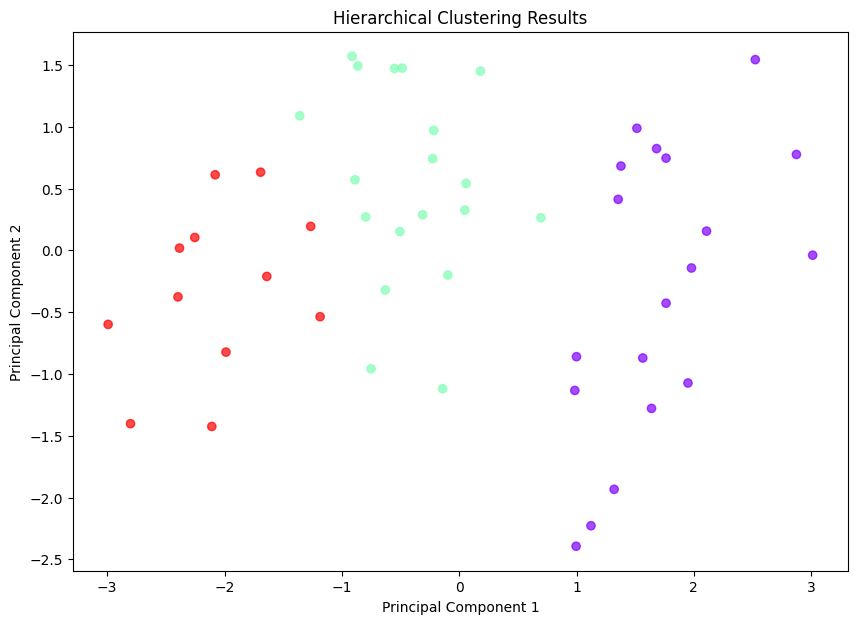

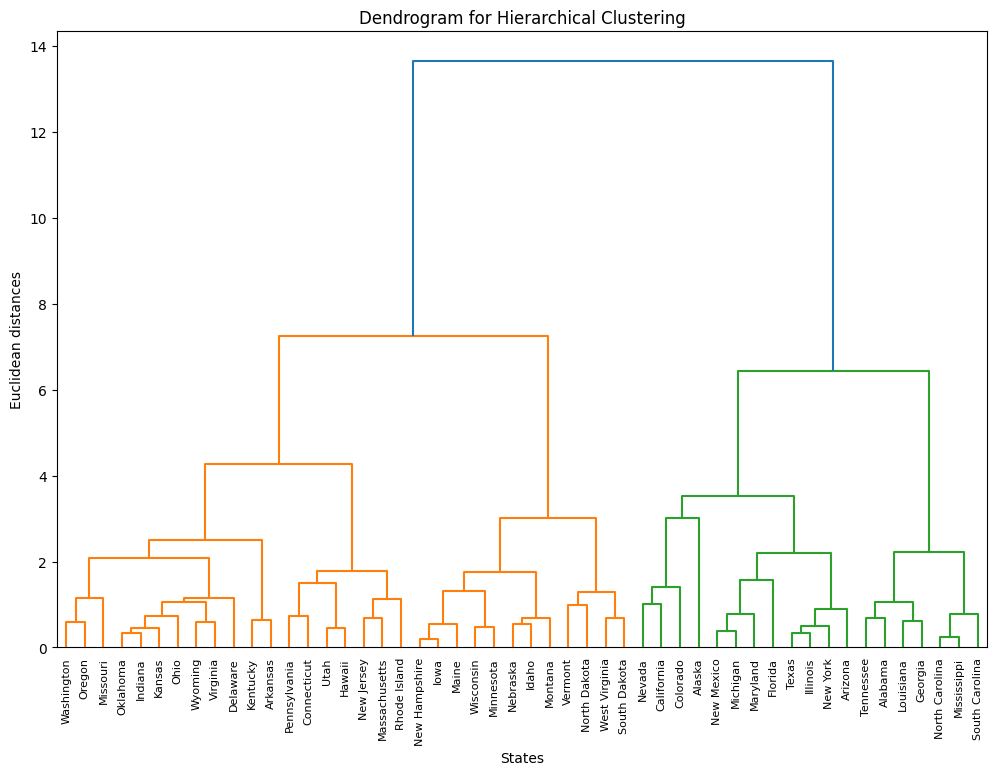

In [19]:
# Using first 3 principal components for clustering (explain 90% of variance)
pca_features = principal_components[:, :3]

# Hierarchical Clustering and Dendrograms
print("Hierarchical Clustering:")
model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
labels = model.fit_predict(pca_features)

# Plot clusters
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='rainbow', alpha=0.7)
plt.title('Hierarchical Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Make Dendrogram
linked = linkage(pca_features, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linked, orientation='top', labels=arrest_df.index.tolist(), distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('States')
plt.ylabel('Euclidean distances')
plt.show()


Hierarchical Results:

1. Clustering
- 3 distinct clusters were identified
- Clusters separate primarily along the overall crime level (Primary Component 1)
- Some overlapping does occur, indicating that urbanization doesn't perfectly separate clusters

2. Dendogram
- Horizontal lines show where clusters merge
- Longer vertical lines indicate larger differences between merged groups
- Tree structure shows natural grouping of stats by crime rate

K-Means Clustering:

Partitions states into clusters by minimizing within-cluster sum of squares. 

K-Means Clustering: 


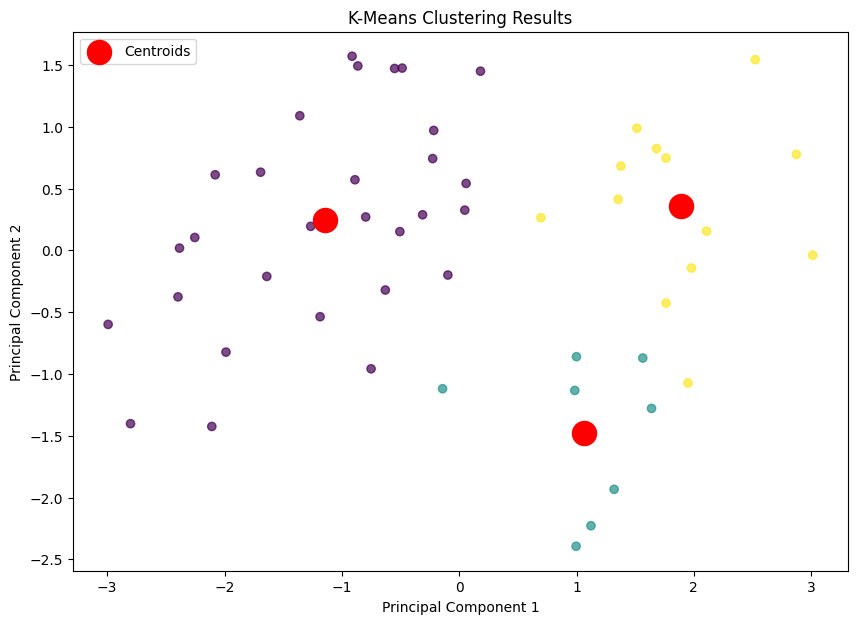

In [20]:
# K-Means Clustering and Dendrograms
print("K-Means Clustering: ")
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_features)

# Plot clusters
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('K-Means Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

K-Means Results: 

- Red X markers - Show cluster centroids or the average state in each cluster
- Clusters form distinct groups along the crime severity axis


Comparing Clustering Results: 

Both methods produced similar overall patterns by grouping the data into 3 distinct clusters: High , Moderate, and Low crime. Hierarchial should be used for exploratory analysis while K-Means should be used for prediction. Results are consistent between both models validating the clustering. Based on clustering results, it does show that crime patterns are more important than geography in determining similarity. 

In [23]:
arrest_df['Hierarchical_Cluster'] = labels
arrest_df['KMeans_Cluster'] = kmeans_labels

print("Average Crime Rates by Hierarchical Clusters:")
print(arrest_df.groupby('Hierarchical_Cluster')[['Murder', 'Assault', 'Rape']].mean().round(2))

print("\nAverage Crime Rates by K-Means Clusters:")
print(arrest_df.groupby('KMeans_Cluster')[['Murder', 'Assault', 'Rape']].mean().round(2))


Average Crime Rates by Hierarchical Clusters:
                      Murder  Assault   Rape
Hierarchical_Cluster                        
0                      12.33   259.32  29.22
1                       6.21   142.05  19.18
2                       3.09    76.00  11.83

Average Crime Rates by K-Means Clusters:
                Murder  Assault   Rape
KMeans_Cluster                        
0                 4.73   111.83  15.82
1                13.94   243.62  21.41
2                10.82   257.38  33.19
